In [142]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.optimize as opt
import sys
import operator
from tqdm import tqdm

np.random.seed(0)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def flat_for(a, f):
    a = a.reshape(-1)
    for i, v in enumerate(a):
        a[i] = f(v)

def sample(n):
    source_xs = [[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]]
    source_ys = [[1.0], [0.0], [1.0], [0.0]]
    source_inds = [random.randint(0,len(source_xs) - 1) for i in range(n)]
    xs = np.matrix([source_xs[i] for i in source_inds]) + np.random.randn(n,2) * 0.2
    ys = np.matrix([source_ys[i] for i in source_inds])
    return xs, ys

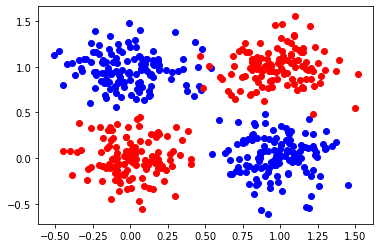

In [143]:
xs, ys = sample(500)
fig, ax = plt.subplots()
class_0 = [x for x, y in zip(xs, ys) if y[0,0] == 0.0]
class_1 = [x for x, y in zip(xs, ys) if y[0,0] == 1.0]
ax.scatter([x[0,0] for x in class_0], [x[0,1] for x in class_0], color='b')
ax.scatter([x[0,0] for x in class_1], [x[0,1] for x in class_1], color='r')
plt.show()

In [147]:
class NeuralNetwork:
    """
    basic neural network with training via backpropagation
        follows notation from Andrew Ng's Machine Learning Coursera Course (week 5)
    """
    
    def __init__(self, layer_sizes, thetas=None):
        self.layer_sizes = layer_sizes
        self.epsilon = 0.25
        np.random.seed(1)
        # one row is added for bias term
        transitions = [layer_sizes[i:i+2] for i in range(0, len(layer_sizes)-1)]
        self.layer_dim_edges = [(t[1],t[0]+1) for t in transitions]
        self.thetas      = thetas if thetas else [np.matrix(np.random.rand(t[0], t[1])) * 2 * self.epsilon - self.epsilon for t in self.layer_dim_edges]
        self.train_j = []
        self.train_gtol = []
        self.lambda_val  = 0.001
        self.num_layers = len(self.thetas)

    def unflatten_thetas(self, flat):
        current = 0
        unflattened = []
        for dims in self.layer_dim_edges:
            count = dims[0] * dims[1]
            unflattened += [np.matrix(np.reshape(flat[current:current+count], dims))]
            current += count
        return unflattened
    
    def flatten(self, ary):
        return np.hstack([np.asarray(ele.flatten()) for ele in ary])[0]
    
    def cost(self, xs, ys):
        m = float(xs.shape[0])
        j = self.lambda_val / (2.0 * m) * np.sum(np.power(self.flatten(self.thetas), 2.0))
        for i in range(xs.shape[0]):
            h_theta = self.forward_propagate(xs[i].T)[-1]
            j += -1.0 / m * (ys[i].dot(np.log(h_theta)) + (1.0 - ys[i]).dot(np.log(1.0 - h_theta)))[0,0]
        return j
    
    def create_f(self, xs, ys, new_thetas):
        nn = NeuralNetwork(self.layer_sizes, self.unflatten_thetas(new_thetas))
        j = nn.cost(xs, ys)
        tup = nn.compute_gradient(xs, ys)
        d = self.flatten(tup[0])
        gtol = tup[1]
        self.train_j.append(j)
        self.train_gtol.append(gtol)
        return (j, d)
        
    def train(self, xs, ys):
        f = lambda new_thetas: self.create_f(xs, ys, new_thetas)
        xopt = opt.fmin_l_bfgs_b(f, self.flatten(self.thetas), pgtol=1e-10) #gtol=1e-10, epsilon=1.0, 
        self.thetas = self.unflatten_thetas(xopt[0])
        return xopt
            
    def forward_propagate(self, x):
        state = x
        activations = [self.add_bias_w(x)]
        for theta in self.thetas[:-1]:
            state = self.layer_step(theta, activations[-1])
            flat_for(state, sigmoid)
            activations.append(self.add_bias_w(state))
        last_step = self.layer_step(self.thetas[-1], activations[-1])
        flat_for(last_step, sigmoid)
        activations.append(last_step)
        return activations
    
    def back_propagate(self, x, y):
        activations = self.forward_propagate(x)
        deltas = [None] * (self.num_layers+1)
        grad = [None] * self.num_layers
        deltas[-1] = activations[-1] - y
        for l in range(self.num_layers-1, 0, -1):
            deltas[l] = np.multiply(self.thetas[l].T.dot(deltas[l+1]),
                                    np.multiply(activations[l], 1.0 - activations[l]))
        for l in range(0, self.num_layers):
            # remove the change in bias term activation when propagating to earlier layers
            delta_sel = deltas[l+1] if l == self.num_layers-1 else deltas[l+1][1:,:]
            grad[l] = delta_sel.dot(activations[l].T)
        return grad
    
    def compute_gradient(self, xs, ys):
        assert(xs.shape[0] == ys.shape[0])
        m = float(len(xs))
        D = self.back_propagate(xs[0].T, ys[0].T)
        for x, y in zip(xs[1:], ys[1:]):
            xyD = self.back_propagate(x.T, y.T)
            for l in range(0, self.num_layers):
                D[l] += xyD[l]
        for l in range(0, self.num_layers):
            D[l] /= m
        D[l][:,1:] += self.lambda_val * self.thetas[l][:,1:]
        flat = self.flatten(D)
        gtol = np.linalg.norm(flat, 2.0)
        return D, gtol
    
    def update(self, D):
        for i in range(0,len(self.thetas)):
            self.thetas[i] -= D[i]
    
    def add_bias_w(self, v):
        return np.vstack([np.matrix([[1]]), v])
    
    def layer_step(self, theta, x_or_z):
        return theta.dot(x_or_z)
    
    def print_thetas(self):
        print("\n\nthetas:")
        for theta in self.thetas:
            print(theta)
            print()
    
    def plot_training_stats(self):
        plt.figure(figsize=[12,8])
        plt.subplot(2,1,1)
        plt.plot(self.train_j)
        plt.title('j')
        plt.subplot(2,1,2)
        plt.plot(self.train_gtol)
        plt.title('gtol')
        
    def plot_classifications(self, xs, ys):
        fig, ax = plt.subplots()

        self_fit = [self.forward_propagate(x.T)[-1] for x in xs]

        def filter_xs(xs, ys, true_class, comparator):
            return [x for x, y, s in zip(xs, ys, self_fit) if y[0,0] == true_class and comparator(s[0,0], 0.5)]

        for sample_class, comparator, color, alpha in [
            (0.0, operator.le, 'b', 0.1),
            (1.0, operator.gt, 'r', 0.1),
            (0.0, operator.gt, 'b', 1.0),
            (1.0, operator.le, 'r', 1.0),
        ]:
            filtered_xs = filter_xs(xs, ys, sample_class, comparator)
            ax.scatter([x[0,0] for x in filtered_xs], [x[0,1] for x in filtered_xs], color=color, alpha=alpha)

        plt.show()

## train with bfgs

In [148]:
layer_sizes = [2, 3, 1]
nn2 = NeuralNetwork(layer_sizes)

xs, ys = sample(1000)

xopt = nn2.train(xs, ys)
nn2.print_thetas()
nn2.cost(xs, ys)

<ipython-input-147-74217553482f>:37: RuntimeWarning: divide by zero encountered in log
  j += -1.0 / m * (ys[i].dot(np.log(h_theta)) + (1.0 - ys[i]).dot(np.log(1.0 - h_theta)))[0,0]




thetas:
[[ -2.06063112  10.40439765 -20.3847614 ]
 [ -2.91980131 -16.0324376    9.92119322]
 [  4.99576444 -11.53739464 -11.20070175]]

[[ 2.85920071 -6.16897257 -6.77268252  5.66289878]]



0.09087300433185201

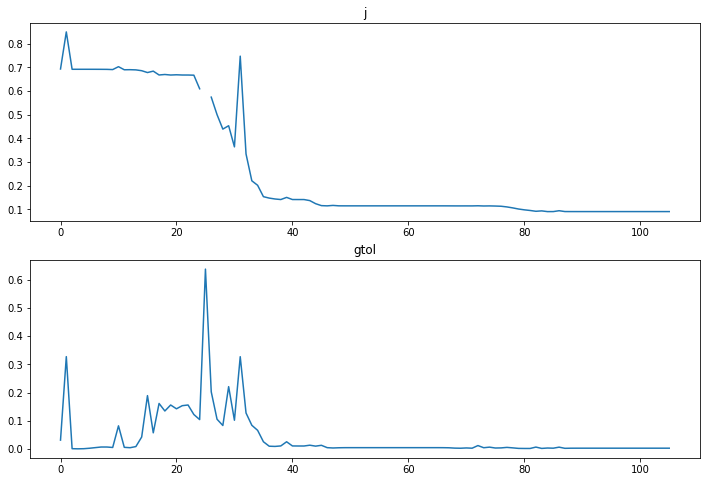

In [149]:
nn2.plot_training_stats()

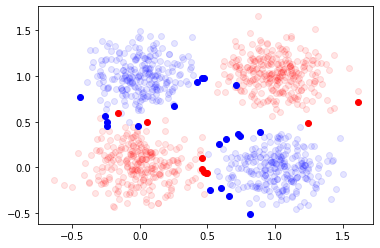

In [150]:
nn2.plot_classifications(xs, ys)

In [170]:
# train by simply updating with -gradient
nn = NeuralNetwork(layer_sizes)
gtols = []
js = []

np.random.seed(0)
itr = 2000
for i in tqdm(range(itr)):
    xs, ys = sample(25)
    D, gtol = nn.compute_gradient(xs, ys)
    gtols.append(gtol)
    js.append(nn.cost(xs, ys))
    nn.update(D)

nn.print_thetas()
nn.cost(xs, ys)

100%|██████████| 2000/2000 [00:14<00:00, 139.37it/s]



thetas:
[[-1.48975789  4.69582518 -7.62283283]
 [ 2.46776632 -7.04962603 -7.11129043]
 [-1.26462617 -7.27068685  4.42049941]]

[[ 2.9545033  -6.72849368  5.72227708 -6.81050965]]



0.11668365359863318

Text(0.5, 1.0, 'gtol')

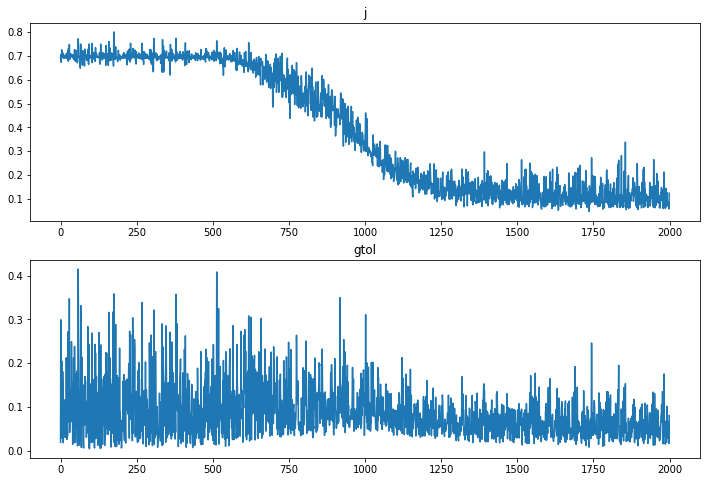

In [171]:
plt.figure(figsize=[12,8])
plt.subplot(2,1,1)
plt.plot(js)
plt.title('j')
plt.subplot(2,1,2)
plt.plot(gtols)
plt.title('gtol')

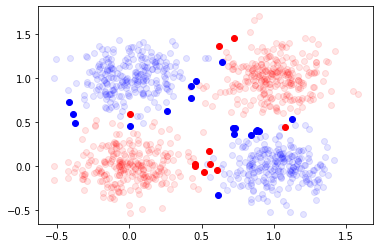

In [172]:
xs, ys = sample(1000)
nn2.plot_classifications(xs, ys)